<a href="https://colab.research.google.com/github/ortall0201/Spotify-Playlist-Recommender-System-Using-NLP/blob/main/Manor/Copy_of_Triplet_Formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triplet Formation

## Creating train ad test sets, with song_mames divided proportionally

In [16]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# call preprocessed data

csv_file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/cleaned_step4.csv'
playlists_df = pd.read_csv(csv_file_path)

In [ ]:
playlists_df.head()

,user_id,artist_name,track_name,playlist_name,song_name,unq_playlist_name,track_word_count
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,(the angels wanna wear my) red shoes,hard rock 2010,elvis costello - (the angels wanna wear my) re...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,7
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,"(what's so funny 'bout) peace, love and unders...",hard rock 2010,elvis costello & the attractions - (what's so ...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,8
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,hard rock 2010,tiffany page - 7 years too late,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,4
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,accidents will happen,hard rock 2010,elvis costello & the attractions - accidents w...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,3
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,hard rock 2010,elvis costello - alison,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,1


In [ ]:
playlists_df.shape

(8827807, 7)

In [ ]:
playlists_df.columns

Index(['user_id', 'artist_name', 'track_name', 'playlist_name', 'song_name',
       'unq_playlist_name', 'track_word_count'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def proportional_split(df, song_column, test_size=0.2, random_state=42):

    train_data = []
    test_data = []

    # Group by the song column
    grouped = df.groupby(song_column)

    for _, group in grouped:
        if len(group) == 1:
            # If only one row, assign it to the train set
            train_data.append(group)
        else:
            # Split the group proportionally
            train_group, test_group = train_test_split(
                group,
                test_size=test_size,
                random_state=random_state
            )
            train_data.append(train_group)
            test_data.append(test_group)

    # Combine all train and test groups
    train_df = pd.concat(train_data).reset_index(drop=True)
    test_df = pd.concat(test_data).reset_index(drop=True)

    return train_df, test_df



In [ ]:
train_df, test_df = proportional_split(playlists_df, song_column='song_name', test_size=0.2)


In [ ]:
train_df.shape

(6918549, 7)

In [ ]:
test_df.shape

(1909258, 7)

In [ ]:
train_df.to_csv('/content/drive/My Drive/Colab Notebooks/Final Project/playlists_train_df.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/Final Project/playlists_test_df.csv', index=False)

In [17]:
path = '/content/drive/My Drive/Colab Notebooks/Final Project/playlists_train_df.csv'
playlists_df = pd.read_csv(path) # assign playlists_df as the train set

In [18]:
# Number of unique artists

playlists_df['artist_name'].nunique()
print(f"Number of unique artists: {playlists_df['artist_name'].nunique()}")

# Number of unique users

unique_users = playlists_df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

# Number of unique songs

unique_songs = playlists_df['song_name'].nunique()
print(f"Number of unique songs: {unique_songs}")

Number of unique artists: 223712
Number of unique users: 15345
Number of unique songs: 1913703


## Triplets generation

In [19]:
import random
from tqdm import tqdm  # For progress tracking

import random
from tqdm import tqdm  # For progress tracking

def generate_triplets(df, max_positives=3, verbose=True):
    """
    Generate triplets with random negative sampling (no precomputed pools).

    Parameters:
    - df: DataFrame with 'playlist_id' and 'song_id'.
    - max_positives: Number of positives to sample per anchor.
    - verbose: Whether to print progress updates.

    Returns:
    - List of triplets (anchor, positive, negative).
    """
    playlists = df.groupby('unq_playlist_name')['song_name'].apply(list).to_dict()
    all_songs = list(df['song_name'].unique())  # Global pool of songs
    triplets = set()  # Use a set to track unique triplets

    # Progress bar if verbose is enabled
    if verbose:
        print("Starting triplet generation...")
        pbar = tqdm(total=len(playlists), desc="Processing playlists")

    for playlist_id, playlist_songs in playlists.items():
        for anchor in playlist_songs:
            if len(playlist_songs) > 1:
                # Sample up to max_positives for this anchor
                positives = random.sample([song for song in playlist_songs if song != anchor],
                                          min(max_positives, len(playlist_songs) - 1))
                for positive in positives:
                    # Randomly sample a negative from the global pool
                    negative = random.choice(all_songs)
                    # Ensure negative is not in the same playlist
                    while negative in playlist_songs:
                        negative = random.choice(all_songs)

                    # Add the triplet
                    triplets.add((anchor, positive, negative))

        # Update progress bar
        if verbose:
            pbar.update(1)

    if verbose:
        pbar.close()
        print(f"Triplet generation complete. Generated {len(triplets)} unique triplets.")

    return list(triplets)



triplets = generate_triplets(playlists_df)



Starting triplet generation...


Processing playlists: 100%|██████████| 213685/213685 [01:23<00:00, 2561.17it/s]


Triplet generation complete. Generated 20721418 unique triplets.


In [39]:
# save triplets as df to avoid crash troubles

triplets_df = pd.DataFrame(list(triplets), columns=['anchor', 'positive', 'negative'])
output_csv_path = '/content/drive/My Drive/Colab Notebooks/Final Project/test_triplets.csv'
triplets_df.to_csv(output_csv_path, index=False)



In [21]:
triplets_df.shape

(20721418, 3)

In [22]:
triplets_df.isna().sum()

,0
anchor,0
positive,0
negative,0


In [23]:
unique_counts = {col: triplets_df[col].nunique() for col in triplets_df.columns}
unique_counts

{'anchor': 1913549, 'positive': 1852751, 'negative': 1913666}

In [1]:
# call triplets back to set - mount drive (1)

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# call triplets back to set - call data (2)
import pandas as pd

csv_file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/test_triplets.csv'
loaded_triplets = pd.read_csv(csv_file_path)
triplets = set(loaded_triplets.itertuples(index=False, name=None))

In [4]:
del loaded_triplets

import gc

gc.collect()

0

In [24]:
triplets_df.head()

,anchor,positive,negative
0,katy perry - dark horse,jason derulo - wiggle (feat. snoop dogg),special request - i adore you
1,will.i.am - fall down,quadron - hey love,josey wales - let go mi hand
2,fu manchu - evil eye,motorhead - ace of spades,"her space holiday - the bullet, the battle, th..."
3,claire de lune - standing on the shore,claire de lune - sonata pathetique,gnawa njoum experience - moussaka - renedictio...
4,hozier - angel of small death and the codeine ...,troye sivan - happy little pill,kidz bop kids - i gotta feeling


In [25]:
triplets_df.shape

(20721418, 3)

In [ ]:
from collections import Counter

# Count how often each song appears as an anchor
anchors = [triplet[0] for triplet in triplets]
anchor_counts = Counter(anchors)

# Compare with the original dataset
all_songs = set(playlists_df['song_name'])
missing_songs = all_songs - set(anchors)

print(f"Number of unique anchors: {len(set(anchors))}")
print(f"Songs missing as anchors: {len(missing_songs)}")
print(f"Most common anchors: {anchor_counts.most_common(5)}")


Number of unique anchors: 1913549
Songs missing as anchors: 154
Most common anchors: [('m83 - midnight city', 5402), ('daft punk - get lucky - radio edit', 4944), ('imagine dragons - radioactive', 4925), ('avicii - wake me up', 4917), ('lorde - royals', 4707)]


In [29]:
# Balance triplet anchors

# Count occurrences of each anchor
anchor_counts = Counter([triplet[0] for triplet in triplets])

# Group triplets by anchor
anchor_to_triplets = {}
for triplet in triplets:
    anchor = triplet[0]
    if anchor not in anchor_to_triplets:
        anchor_to_triplets[anchor] = []
    anchor_to_triplets[anchor].append(triplet)

# Downsample triplets for dominant anchors
balanced_triplets = []
for anchor, triplet_list in anchor_to_triplets.items():
    if len(triplet_list) > 100:
        # Randomly sample to limit the number of triplets
        balanced_triplets.extend(random.sample(triplet_list, 100))
    else:
        # Keep all triplets for non-dominant anchors
        balanced_triplets.extend(triplet_list)

triplets = balanced_triplets



In [30]:
from collections import Counter

# Count how often each song appears as an anchor after anchor balancing
anchors = [triplet[0] for triplet in triplets]
anchor_counts = Counter(anchors)

# Compare with the original dataset
all_songs = set(playlists_df['song_name'])
missing_songs = all_songs - set(anchors)

print(f"Number of unique anchors: {len(set(anchors))}")
print(f"Songs missing as anchors: {len(missing_songs)}")
print(f"Most common anchors: {anchor_counts.most_common(5)}")


Number of unique anchors: 1913549
Songs missing as anchors: 154
Most common anchors: [('katy perry - dark horse', 100), ('will.i.am - fall down', 100), ('hozier - angel of small death and the codeine scene', 100), ('tv on the radio - quartz', 100), ('ed sheeran - drunk', 100)]


In [31]:
# Count how often each positive pair appears
positive_pairs = [(triplet[0], triplet[1]) for triplet in triplets]
positive_pair_counts = Counter(positive_pairs)

print(f"Number of unique positive pairs: {len(set(positive_pairs))}")
print(f"Most common positive pairs: {positive_pair_counts.most_common(5)}")


Number of unique positive pairs: 14877660
Most common positive pairs: [(('elbow - colour fields', 'elbow - real life (angel)'), 15), (('pablo alboran - yo no lo sabia', 'pablo alboran - extasis'), 14), (('aloe blacc - ticking bomb', 'aloe blacc - love is the answer'), 14), (('robin thicke - top of the world', 'robin thicke - the good life'), 13), (('jhene aiko - wth', 'jhene aiko - the worst'), 13)]


In [32]:
# Count how often each song appears as a negative
negatives = [triplet[2] for triplet in triplets]
negative_counts = Counter(negatives)

print(f"Number of unique negatives: {len(set(negatives))}")
print(f"Most common negatives: {negative_counts.most_common(5)}")


Number of unique negatives: 1913212
Most common negatives: [('marcus d - third person', 25), ('tito el bambino - booty', 25), ('andy martin - kamikaze', 25), ('various - my sweet lord', 25), ('adam ezra group - another sunshine', 25)]


In [33]:
# Count how many playlists contribute to triplets
playlist_ids_in_triplets = set(playlists_df[playlists_df['song_name'].isin(anchors)]['unq_playlist_name'])

print(f"Number of playlists in dataset: {playlists_df['unq_playlist_name'].nunique()}")
print(f"Number of playlists in triplets: {len(playlist_ids_in_triplets)}")


Number of playlists in dataset: 213685
Number of playlists in triplets: 213531


In [34]:
print(f"Total triplets: {len(triplets)}")
print(f"Unique triplets: {len(set(triplets))}")
print(f"Proportion of unique triplets: {len(set(triplets)) / len(triplets):.2f}")


Total triplets: 15695857
Unique triplets: 15695857
Proportion of unique triplets: 1.00


In [35]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def check_triplet_balance_ratios(df, triplets):
    """
    Check balance of triplets by analyzing song and playlist ratios.

    Parameters:
    - df: Original DataFrame with 'unq_playlist_name' and 'song_name'.
    - triplets: List of generated triplets (anchor, positive, negative).

    Returns:
    - None. Displays summary statistics and visualizations.
    """
    # Extract anchor, positive, and negative songs
    anchors = [triplet[0] for triplet in triplets]
    positives = [triplet[1] for triplet in triplets]
    negatives = [triplet[2] for triplet in triplets]

    # Count occurrences in triplets
    anchor_counts = Counter(anchors)
    positive_counts = Counter(positives)
    negative_counts = Counter(negatives)

    # Count occurrences in the dataset
    dataset_song_counts = df['song_name'].value_counts()
    total_songs = len(dataset_song_counts)

    # Playlist coverage
    total_playlists = df['unq_playlist_name'].nunique()
    playlists_in_triplets = df[df['song_name'].isin(anchors)]['unq_playlist_name'].nunique()
    playlist_coverage_ratio = playlists_in_triplets / total_playlists

    # Unique vs. Total Triplets Ratio
    unique_triplets_ratio = len(set(triplets)) / len(triplets)

    # Display summary statistics
    print(f"Total songs in dataset: {total_songs}")
    print(f"Total playlists in dataset: {total_playlists}")
    print(f"Playlists contributing to triplets: {playlists_in_triplets} ({playlist_coverage_ratio:.2%})")
    print(f"Unique triplets: {len(set(triplets))} / Total triplets: {len(triplets)} ({unique_triplets_ratio:.2%})")


check_triplet_balance_ratios(playlists_df, triplets)


Total songs in dataset: 1913703
Total playlists in dataset: 213685
Playlists contributing to triplets: 213531 (99.93%)
Unique triplets: 15695857 / Total triplets: 15695857 (100.00%)


Summary Statistics:
       dataset_ratio  anchor_ratio  positive_ratio  negative_ratio
count   1.913703e+06  1.913703e+06    1.913703e+06    1.913703e+06
mean    5.225471e-07  5.225471e-07    5.225471e-07    5.225471e-07
std     2.498352e-06  9.949734e-07    1.748945e-06    1.823333e-07
min     1.445390e-07  0.000000e+00    0.000000e+00    0.000000e+00
25%     1.445390e-07  1.911332e-07    1.274222e-07    3.822665e-07
50%     1.445390e-07  1.911332e-07    1.911332e-07    5.096886e-07
75%     2.890780e-07  3.822665e-07    3.822665e-07    6.371108e-07
max     2.607483e-04  6.371108e-06    1.666045e-04    1.592777e-06

Top-K Most Common Anchors:
                                                                                            song_name  \
song_name                                                                                               
m83 - midnight city                                                               m83 - midnight city   
daft punk - get lucky - radio edit

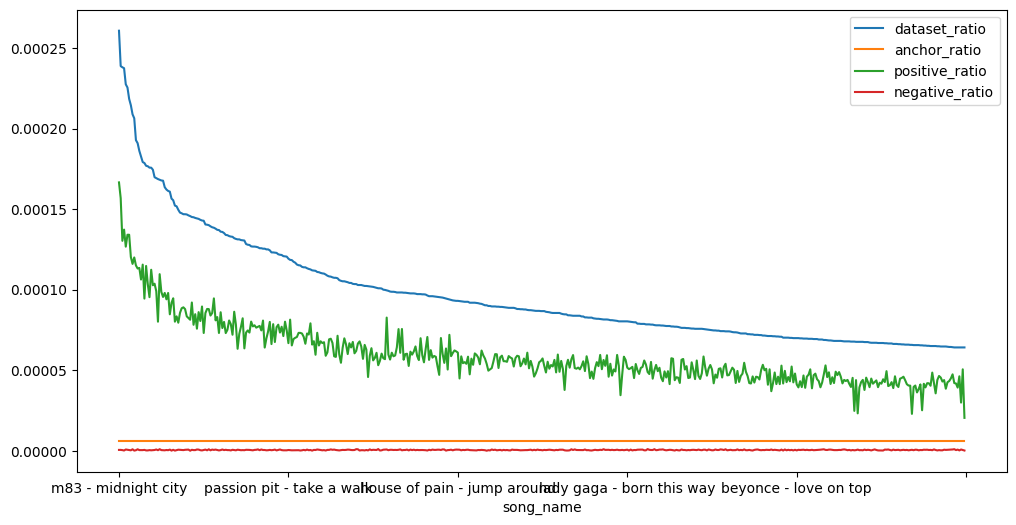

In [36]:
def check_triplet_balance_ratios_light(df, triplets, top_k=10):
    """
    Check balance of triplets with summary statistics and light visualizations.

    Parameters:
    - df: Original DataFrame with 'unq_playlist_name' and 'song_name'.
    - triplets: List of generated triplets (anchor, positive, negative).
    - top_k: Number of top and bottom songs to display in statistics.

    Returns:
    - None. Prints summary statistics and displays key insights.
    """
    from collections import Counter
    import pandas as pd

    # Extract anchor, positive, and negative songs
    anchors = [triplet[0] for triplet in triplets]
    positives = [triplet[1] for triplet in triplets]
    negatives = [triplet[2] for triplet in triplets]

    # Count occurrences in triplets
    anchor_counts = Counter(anchors)
    positive_counts = Counter(positives)
    negative_counts = Counter(negatives)

    # Count occurrences in the dataset
    dataset_song_counts = df['song_name'].value_counts()

    # Calculate ratios
    song_ratios = pd.DataFrame({
        'song_name': dataset_song_counts.index,
        'dataset_ratio': dataset_song_counts / dataset_song_counts.sum(),
        'anchor_ratio': [anchor_counts[song] / len(anchors) if song in anchor_counts else 0 for song in dataset_song_counts.index],
        'positive_ratio': [positive_counts[song] / len(positives) if song in positive_counts else 0 for song in dataset_song_counts.index],
        'negative_ratio': [negative_counts[song] / len(negatives) if song in negative_counts else 0 for song in dataset_song_counts.index],
    })

    # Summary statistics
    print("Summary Statistics:")
    print(song_ratios.describe())

    # Top-K and Bottom-K Songs
    print("\nTop-K Most Common Anchors:")
    print(song_ratios.nlargest(top_k, 'anchor_ratio')[['song_name', 'anchor_ratio']])

    print("\nTop-K Most Common Positives:")
    print(song_ratios.nlargest(top_k, 'positive_ratio')[['song_name', 'positive_ratio']])

    print("\nTop-K Most Common Negatives:")
    print(song_ratios.nlargest(top_k, 'negative_ratio')[['song_name', 'negative_ratio']])

    print("\nBottom-K Least Common Anchors:")
    print(song_ratios.nsmallest(top_k, 'anchor_ratio')[['song_name', 'anchor_ratio']])

    # Optionally, plot subsampled ratios
    subset_ratios = song_ratios.head(500)  # Limit to top 500 for plotting
    subset_ratios.plot(x='song_name', y=['dataset_ratio', 'anchor_ratio', 'positive_ratio', 'negative_ratio'], kind='line', figsize=(12, 6))

check_triplet_balance_ratios_light(playlists_df, triplets)



# Preparing songs for incorporation in triplets as normalized tensors

## Embedding Song names to numeric vectors using Sentence-BERT pre-trained language model

In [5]:
# Extract unique songs from triplets
unique_songs = list(set([t[0] for t in triplets] + [t[1] for t in triplets] + [t[2] for t in triplets]))
print(f"Total unique songs: {len(unique_songs)}")


Total unique songs: 1913703


In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load pre-trained Sentence-BERT model
model = SentenceTransformer('all-mpnet-base-v2')

# Convert song names to embeddings with progress monitoring
song_embeddings = {}
print("Starting to encode song embeddings...")

for song in tqdm(unique_songs, desc="Encoding songs", unit="song"):
    song_embeddings[song] = model.encode(song)

print(f"Encoding complete. Total songs encoded: {len(song_embeddings)}")


### Saving embeddings file for safe keeping

In [ ]:
import pickle

# Save the dictionary to a file
with open("song_embeddings.pkl", "wb") as f:
    pickle.dump(song_embeddings, f)  # Replace 'song_embeddings' with your dictionary or list

### Upload pickle file

In [6]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/song_embeddings.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    song_embeddings = pickle.load(f)

print(f"Loaded {len(song_embeddings)} embeddings.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1913703 embeddings.


In [7]:
# Check the number of entries
print(f"Number of songs: {len(song_embeddings)}")

# Inspect the first few entries
for song, embedding in list(song_embeddings.items())[:5]:
    print(f"Song: {song}, Embedding: {embedding[:5]}...")  # Print the first 5 dimensions


Number of songs: 1913703
Song: d.c. larue - cathedrals, Embedding: [-0.01308458  0.08578954 -0.02307864  0.10347608 -0.03594142]...
Song: lorie - la positive attitude, Embedding: [ 0.03185854  0.04972399 -0.00537229  0.01272503  0.02244148]...
Song: camila rondon - teimoso, Embedding: [-0.00528201 -0.01931837 -0.0124181   0.00089441  0.05253233]...
Song: ulf lundell - alska med framlingen, Embedding: [ 0.05792086 -0.01925061  0.01903067  0.05852388 -0.00313933]...
Song: cannibal corpse - return to flesh, Embedding: [ 0.05575536  0.04524249 -0.00620269 -0.03061887 -0.02663926]...


## Noralizing embeddings

In [8]:
from sklearn.preprocessing import normalize
from tqdm import tqdm

# Normalize embeddings with progress bar
print("Starting normalization of song embeddings...")
for song, embedding in tqdm(song_embeddings.items(), desc="Normalizing embeddings", unit="song"):
    song_embeddings[song] = normalize(embedding.reshape(1, -1))[0]

print("Normalization complete.")


Starting normalization of song embeddings...


Normalizing embeddings: 100%|██████████| 1913703/1913703 [06:53<00:00, 4628.32song/s]

Normalization complete.


# Transforming triplets as normalized tensors triplets

In [9]:
import os

def save_triplet_batches_to_disk(triplets, normalized_embeddings, batch_size, save_dir):
    """
    Converts triplets to tensors and saves batches to disk.

    Args:
    - triplets: List of triplets (anchor, positive, negative).
    - normalized_embeddings: Dictionary of precomputed normalized embeddings.
    - batch_size: Number of triplets per batch.
    - save_dir: Directory to save the batches.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Ensure triplets are a list (convert if needed)
    if isinstance(triplets, set):
        triplets = list(triplets)

    num_batches = len(triplets) // batch_size + (len(triplets) % batch_size != 0)

    print("Converting triplets to tensors and saving batches...")
    pbar = tqdm(total=len(triplets), desc="Processing Triplets")

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(batch_start + batch_size, len(triplets))
        batch_triplets = triplets[batch_start:batch_end]

        # Convert triplets to tensors
        batch_data = [
            (
                torch.tensor(normalized_embeddings[anchor], dtype=torch.float),
                torch.tensor(normalized_embeddings[positive], dtype=torch.float),
                torch.tensor(normalized_embeddings[negative], dtype=torch.float),
            )
            for anchor, positive, negative in batch_triplets
        ]

        # Save batch to disk
        batch_file = os.path.join(save_dir, f"batch_{batch_idx}.pt")
        torch.save(batch_data, batch_file)
        pbar.update(len(batch_triplets))

    pbar.close()
    print(f"Saved batches to {save_dir}")


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

save_dir = "./triplet_batches"
save_triplet_batches_to_disk(triplets, song_embeddings, batch_size=200000, save_dir=save_dir)


Converting triplets to tensors and saving batches...


Processing Triplets: 100%|██████████| 15695857/15695857 [1:13:38<00:00, 3551.93it/s]


Saved batches to ./triplet_batches


# Preparing Siamese Network Model

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=32):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.fc(x)


In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)  # Euclidean distance
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.relu(pos_dist - neg_dist + self.margin).mean()
        return loss


In [13]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_dim = len(next(iter(song_embeddings.values())))  # Dimensionality of your embeddings
model = SiameseNetwork(input_dim)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)

In [14]:
import os

def load_batch_from_disk(batch_index, save_dir):
    """
    Loads a single batch from disk.

    Args:
    - batch_index: Index of the batch to load.
    - save_dir: Directory where batches are saved.

    Returns:
    - List of tensors (anchor, positive, negative).
    """
    batch_file = os.path.join(save_dir, f"batch_{batch_index}.pt")
    print(f"Loading batch {batch_index} from {batch_file}...")
    return torch.load(batch_file)


In [15]:
from torch.utils.data import DataLoader, Dataset

class SingleBatchDataset(Dataset):
    def __init__(self, batch_data):
        """
        Dataset for a single batch of triplets.

        Args:
        - batch_data: List of tensors (anchor, positive, negative).
        """
        self.batch_data = batch_data

    def __len__(self):
        return len(self.batch_data)

    def __getitem__(self, idx):
        return self.batch_data[idx]

# Create a DataLoader for the loaded batch
def create_dataloader(batch_data, batch_size=32):
    dataset = SingleBatchDataset(batch_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [16]:
def train_on_batch(model, dataloader, optimizer, criterion, device, num_epochs=1):
    """
    Trains the model on a single batch for multiple epochs.

    Args:
    - model: The Siamese network.
    - dataloader: DataLoader for the current batch.
    - optimizer: Optimizer for training.
    - criterion: Loss function (e.g., TripletLoss).
    - device: Device to train on ('cuda' or 'cpu').
    - num_epochs: Number of epochs to train on this batch.

    Returns:
    - Average loss for the last epoch.
    """
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"Training Epoch {epoch + 1}/{num_epochs}...")

        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            # Compute loss
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {avg_loss:.4f}")

    return avg_loss



In [17]:
num_batches = len(os.listdir(save_dir))  # Total number of saved batches

for batch_index in range(num_batches):
    # Step 2: Load the batch
    batch_data = load_batch_from_disk(batch_index, save_dir)

    # Step 3: Create a DataLoader
    dataloader = create_dataloader(batch_data, batch_size=32)

    # Step 4: Train the model on the batch
    batch_loss = train_on_batch(model, dataloader, optimizer, criterion, device, num_epochs=10)
    print(f"Batch {batch_index + 1}/{num_batches}: Loss = {batch_loss:.4f}")


Loading batch 0 from ./triplet_batches/batch_0.pt...


<ipython-input-14-cf5a01c14251>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(batch_file)


Training Epoch 1/10...
Epoch 1/10: Loss = 0.4802
Training Epoch 2/10...
Epoch 2/10: Loss = 0.4180
Training Epoch 3/10...
Epoch 3/10: Loss = 0.3878
Training Epoch 4/10...
Epoch 4/10: Loss = 0.3658
Training Epoch 5/10...
Epoch 5/10: Loss = 0.3461
Training Epoch 6/10...
Epoch 6/10: Loss = 0.3282
Training Epoch 7/10...
Epoch 7/10: Loss = 0.3117
Training Epoch 8/10...
Epoch 8/10: Loss = 0.2966
Training Epoch 9/10...
Epoch 9/10: Loss = 0.2834
Training Epoch 10/10...
Epoch 10/10: Loss = 0.2711
Batch 1/79: Loss = 0.2711
Loading batch 1 from ./triplet_batches/batch_1.pt...
Training Epoch 1/10...
Epoch 1/10: Loss = 0.4156
Training Epoch 2/10...
Epoch 2/10: Loss = 0.3686
Training Epoch 3/10...
Epoch 3/10: Loss = 0.3419
Training Epoch 4/10...
Epoch 4/10: Loss = 0.3206
Training Epoch 5/10...
Epoch 5/10: Loss = 0.3027
Training Epoch 6/10...
Epoch 6/10: Loss = 0.2866
Training Epoch 7/10...
Epoch 7/10: Loss = 0.2723
Training Epoch 8/10...
Epoch 8/10: Loss = 0.2596
Training Epoch 9/10...
Epoch 9/10: Lo

In [18]:
torch.save(model.state_dict(), "siamese_network.pth")
print("Model saved as siamese_network.pth")


Model saved as siamese_network.pth


In [19]:
# Define the Google Drive path
drive_path = "/content/drive/My Drive/siamese_network.pth"

# Copy the model to Google Drive
!cp siamese_network.pth "$drive_path"
print(f"Model saved to Google Drive at {drive_path}")

Model saved to Google Drive at /content/drive/My Drive/siamese_network.pth


Misc.

In [ ]:
import pickle

# Load the file in Jupyter Notebook
with open("song_embeddings.pkl", "rb") as f:
    song_embeddings = pickle.load(f)

print(f"Loaded {len(song_embeddings)} embeddings.")


In [ ]:
!ls /content/


sample_data		song_embeddings.7z.003	song_embeddings.7z.006	song_embeddings.7z.009
song_embeddings.7z.001	song_embeddings.7z.004	song_embeddings.7z.007	song_embeddings.7z.010
song_embeddings.7z.002	song_embeddings.7z.005	song_embeddings.7z.008	song_embeddings.7z.011


In [ ]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!ls -lh /content/


total 5.2G
drwxr-xr-x 1 root root 4.0K Jan 16 14:29 sample_data
-rw-r--r-- 1 root root 500M Jan 19 08:30 song_embeddings.7z.001
-rw-r--r-- 1 root root 500M Jan 19 08:39 song_embeddings.7z.002
-rw-r--r-- 1 root root 501M Jan 19 08:56 song_embeddings.7z.003
-rw-r--r-- 1 root root 500M Jan 19 09:01 song_embeddings.7z.004
-rw-r--r-- 1 root root 500M Jan 19 09:11 song_embeddings.7z.005
-rw-r--r-- 1 root root 500M Jan 19 09:19 song_embeddings.7z.006
-rw-r--r-- 1 root root 500M Jan 19 09:28 song_embeddings.7z.007
-rw-r--r-- 1 root root 500M Jan 19 09:39 song_embeddings.7z.008
-rw-r--r-- 1 root root 500M Jan 19 09:46 song_embeddings.7z.009
-rw-r--r-- 1 root root 500M Jan 19 09:54 song_embeddings.7z.010
-rw-r--r-- 1 root root 246M Jan 19 09:59 song_embeddings.7z.011


In [ ]:
!7z x -t7z /content/song_embeddings.7z.001 -o/content/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 524288000 bytes (500 MiB)

Extracting archive: /content/song_embeddings.7z.001
ERROR: /content/song_embeddings.7z.001
/content/song_embeddings.7z.001
Open ERROR: Can not open the file as [7z] archive


ERRORS:
Unexpected end of archive
  0%    
Can't open as archive: 1
Files: 0
Size:       0
Compressed: 0


In [ ]:
!7z x /content/song_embeddings.7z.001 -o/content/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 524288000 bytes (500 MiB)

Extracting archive: /content/song_embeddings.7z.001
  0% 1 Open           ERROR: /content/song_embeddings.7z.001
song_embeddings.7z
Open ERROR: Can not open the file as [7z] archive


ERRORS:
Headers Error
WARNINGS:
There are data after the end of archive
  0%    
Can't open as archive: 1
Files: 0
Size:       0
Compressed: 0


In [ ]:
import pickle

# Load the decompressed pickle file
with open('/content/song_embeddings.pkl', 'rb') as f:
    song_embeddings = pickle.load(f)

print(f"Loaded {len(song_embeddings)} embeddings.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# # Delete unused variables
del loaded_triplets

# # Delete multiple variables
# del var1, var2, var3

import gc

# # Run garbage collector
gc.collect()


# import torch

# # Clear GPU memory
# torch.cuda.empty_cache()


0